# Quantum emitter example

In this example we will demonstrate an example of a neural network based control scheme for pumping a quantum emitter. We will simulate the overlap of an incident optical mode on with the preferred mode of the emitter. Note that since this example is illustrative we will not perform a full quantum treatment of the problem, but instead assume that sufficient overlap of the modes implies good mode matching and therefore, efficient pumping of the emitter.

In [1]:
# import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from tqdm import tqdm
import tensorflow as tf128

from moku.nn import LinnModel, save_linn

from emitter_simulator import QuantumEmitter

# set the seed for repeatability
np.random.seed(7)
tf128.random.set_seed(7)

2024-12-10 23:52:30.477962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733874750.528329   26173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733874750.537023   26173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 23:52:30.805650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The examples included in the `nn` package will allow us to simulate the emitter and the incident mode. We simulate this by assuming a Gaussian beam profile for both the emitter and incident mode. To simplify the problem, we will assume a fixed mode size and assume the only perturbations to the system are translations of the beam in the x-y plane and pointing errors with angles defined between the z-x and z-y axes. A diagrammatic representation of this is shown below:

<div>
<img src="attachment:20f845a2-08a3-4cad-9e7f-c3b87b46ceff.png" width="500"/>
</div>

We can plot the profile of the field as a function of x and y. At `z=0` there beam converges to the waist size but the radius of curvature becomes infinite, so instead we plot as $z \rightarrow 0$. We should a Gaussian beam with a 1/e beam diameter equal to the waist we defined.

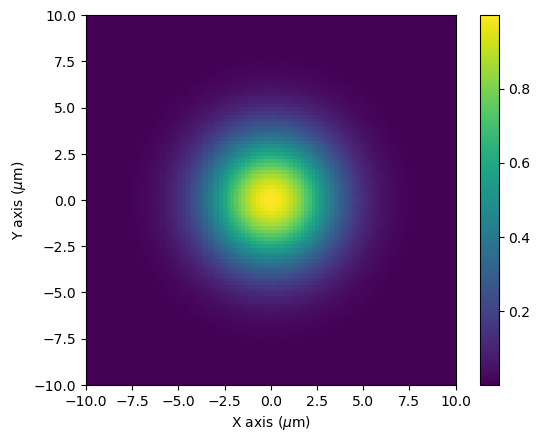

In [2]:
# define a space over which to plot, in this case 10um x 10um
x = np.linspace(-10e-6, 10e-6, 100)
X, Y = np.meshgrid(x, x, indexing='ij')

# define the emitter so we can simulate it
qe_sim = QuantumEmitter(wavelength=780e-9, waist=5e-6)
qe_sim.set_XY(X, Y)

# get the observable beam intensity
intensity = np.abs(qe_sim.E(X, Y, 1e-10))**2
plt.imshow(intensity, extent=[-10,10,-10,10])
plt.xlabel('X axis ($\mu$m)')
plt.ylabel('Y axis ($\mu$m)')
plt.colorbar()
plt.show()

To simulate misalignment of the input beam we wish for our control parameters to perform a random walk over time. To do this we will first define a random walk function which uses the `step_size` argument to determine the variance of the jump at each point. The `input_array` is expected to the series of time points over which the walk is generated. The random walk will always stay within the domain `[-1, 1]` so that we may scale the walk to the relevant parameter bounds.

In [3]:
def random_walk(step_size, input_array, random_start=False):
    # start at 0 or some value in the domain
    if random_start:
        running_value = np.random.uniform(-1,1,1)[0]
    else:
        running_value = 0

    # generate an array of random steps
    output_array = np.random.normal(0, step_size, (input_array.size, 1))
    output_array[0] = running_value   # set the initial value of the walk  

    # for each item determine add the previous position to the walk and clip with the bounds
    for idx in range(output_array.shape[0]):
        if idx != 0:
            output_array[idx] = np.clip(output_array[idx] + output_array[idx - 1], -1, 1)

    return output_array

We can see the kind of random walk we are generating and gauge how severe we would like our driift to be.

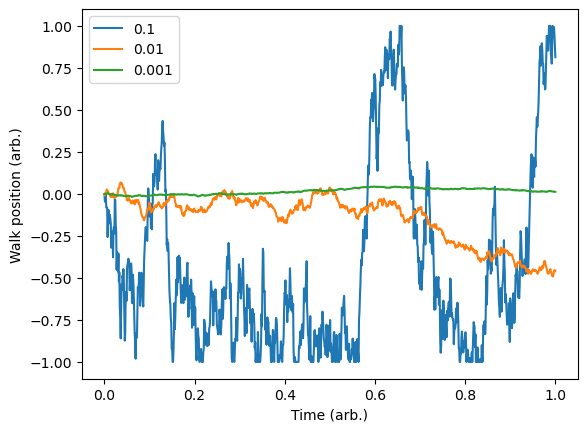

In [4]:
# generate a time base and plot random walks for different step sizes
T = np.linspace(0,1,1000)

# plot different step sizes for comparison
steps = [0.1, 0.01, 0.001]
for step_size in steps:
    walk = random_walk(step_size, T)
    plt.plot(T, walk)

plt.legend(steps)
plt.xlabel('Time (arb.)')
plt.ylabel('Walk position (arb.)')
plt.show()

# Simulation example

We now will run our simulation to generate some training data which will be used to teach the model what corrections we need to make. The model will map observed difference in counts from each modulation to the the best action to perform at a given time step, effectively performing a single shot correction. Since we have centered the target beam at the coordinates (0, 0), and with 0 angle with respect to the z-axis, the ideal correction to perform is simply the negative of our current state. Note that the neural network model does not have access to the absolute position of the beam within the space, but rather is inferring the best action for a set of observables, in this case the difference in counts with each respective modulation. 

We start by defining a random walk for each of the control parameters:

In [5]:
# time base over which to simulate
T = np.linspace(0, 1, 2500)

# generate the random walks
X_offset= random_walk(0.1, T)
Y_offset = random_walk(0.1, T)
X_angle = random_walk(0.1, T)
Y_angle = random_walk(0.1, T)

# set the scale of each variable accordingly These are scaled to bounds for which our simulation makes sense.
X_offset *= 4e-6
Y_offset *= 4e-6
X_angle += 1
X_angle *= 5
Y_angle += 1
Y_angle *= 5

Next we will simulate the random walk of each parameter at a given timestep while recording the counts without the correction, as well as the differential counts as a function of the modulations.

In [6]:
counts = np.zeros(T.size)
mod_counts = np.zeros((T.size, 4))
corrections = np.zeros((T.size, 4))

for i in tqdm(range(T.size)):
    # get the new beam params
    x_off = X_offset[i]
    y_off = Y_offset[i]
    x_ang = X_angle[i] * np.pi / 180
    y_ang = Y_angle[i] * np.pi / 180

    # calculate the shears and new angles
    offsets = (x_off, y_off)
    shears = (qe_sim.new_scale(np.pi/2 - x_ang),qe_sim.new_scale(np.pi/2 - y_ang))
    angles = [np.pi/2 - x_ang, np.pi/2 - y_ang]

    # run the step, save values
    all_counts = qe_sim.time_step(offsets, shears, angles)
    base_count = qe_sim.get_counts()
    mod_counts[i] = all_counts
    counts[i] = base_count
    corrections[i] = np.array([0,0,1,1]) - np.array([*offsets, *shears]).flatten()

100%|██████████| 2500/2500 [00:13<00:00, 188.38it/s]


It is important to note that we are able to generate a training data set in this way as we can simulate the system and therefore know the ideal correction should be. It may also be able to construct a training set from measured data if the ideal correction can also be inferred or calculated. In the abscence of this, however, it may still be possible to construct a training set using reinforcement learning methods such as q-learning. An in-depth discussion of these methods is outside the scope of this tutorial, but instead may be found here: [Goodfellow-Ch14](https://www.deeplearningbook.org/contents/autoencoders.html)

## Model definition and training

Having created our training set we can now train the model to perform the corrections. We will use a feed-forward multi-layer perceptron for this with 4 intermediate layers. The intermediate layers will all have a ReLU activation function. 

In [7]:
#constructing  the model
quant_mod = LinnModel()
quant_mod.set_training_data(training_inputs=mod_counts, training_outputs=corrections)

# define the five layer model
model_definition = [(100, 'relu'),(100, 'relu'), (64, 'relu'), (64, 'relu'), (4,'linear')]
quant_mod.construct_model(model_definition, show_summary=True)

2024-12-10 23:52:56.914549: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer               │ (None, 100)            │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_1             │ (None, 100)            │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_2             │ (None, 64)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_3             │ (None, 64)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_4             │ (None, 4)              │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,484 (83.92 KB)

 Trainable params: 21,484 (83.92 KB)

 Non-trainable params: 0 (0.00 B)

We will train this model up to 500 epochs using early-stopping to ensure we do not overfit. We will also us a 10% validation split so that we may monitor our progress. On completion of the training we can view the training history to see how well the model is performing.

In [8]:
history = quant_mod.fit_model(epochs=500, es_config={'patience':50, 'restore':True}, validation_split=0.1)

Value for monitor missing. Using default:val_loss.


Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2280 - val_loss: 0.2683
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0686 - val_loss: 0.2195
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0556 - val_loss: 0.2160
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0513 - val_loss: 0.2162
Epoch 5/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0481 - val_loss: 0.2165
Epoch 6/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0457 - val_loss: 0.2169
Epoch 7/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0437 - val_loss: 0.2202
Epoch 8/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422 - val_loss: 0.2204
Epoch 9/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0407 - val_loss: 0.2201
Epoch 10/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394 - val_loss: 0.2184
Epoch 11/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0382 - val_loss: 0.2203
Epoch 12/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

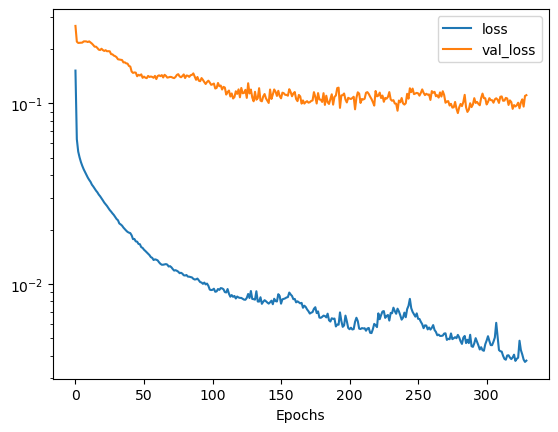

In [9]:
# plot the loss and validation loss as a function of epoch to see how our training went.
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

Now that we have a trained model we should simulate the system again while applying the corrections to view the new performance of the model. We can compare these to the uncorrected results that we calculated earlier. 

In [10]:
preds = quant_mod.predict(mod_counts, scale=True, unscale_output=True)
counts_cor = np.zeros(T.size)

for i in tqdm(range(T.size)):
    # get the new beam params
    x_off = X_offset[i]
    y_off = Y_offset[i]
    x_ang = X_angle[i] * np.pi / 180
    y_ang = Y_angle[i] * np.pi / 180

    # calculate the shears and new angles
    offsets = (x_off, y_off)
    shears = (qe_sim.new_scale(np.pi/2 - x_ang),qe_sim.new_scale(np.pi/2 - y_ang))
    angles = [np.pi/2 - x_ang, np.pi/2 - y_ang]

    # run the step before perofming the correction
    _ = qe_sim.time_step(offsets, shears, angles)
    
    _ = qe_sim.time_step((offsets[0]+preds[i][0],offsets[1]+preds[i][1]), (shears[0]+preds[i][2],shears[1]+preds[i][3]), angles)
    cnt_cor = qe_sim.get_counts()
    counts_cor[i] = cnt_cor

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


100%|██████████| 2500/2500 [00:26<00:00, 92.59it/s] 


Finally we can plot and calculate the our average fidelity compared to our random walk.

Corrected [mean:std]:	 [0.99, 0.02]
Uncorrected [mean:std]:	 [0.58, 0.17]


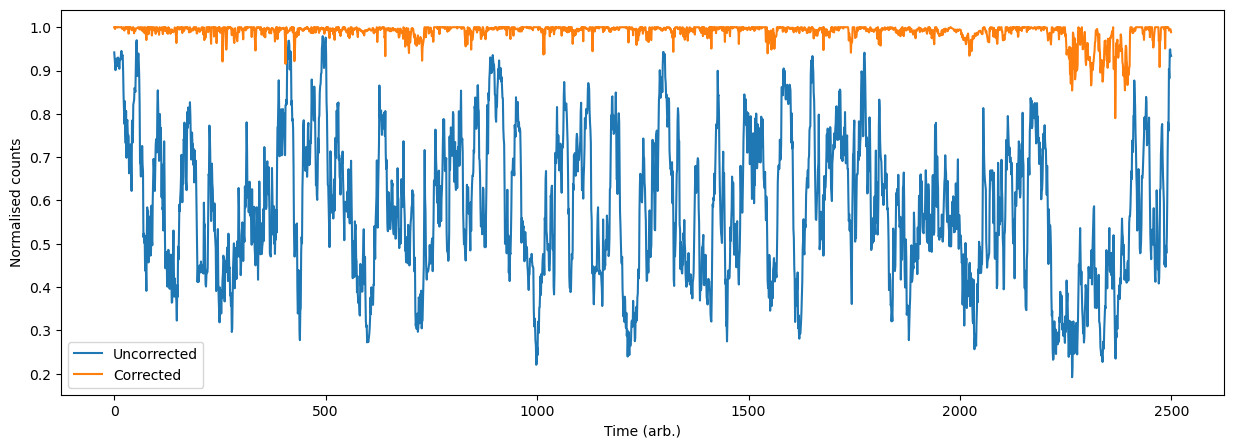

In [11]:
print("Corrected [mean:std]:\t [%.2f, %.2f]" % (np.mean(counts_cor / 2**16), np.std(counts_cor / 2**16)))
print("Uncorrected [mean:std]:\t [%.2f, %.2f]" % (np.mean(counts / 2**16), np.std(counts / 2**16)))

plt.figure(figsize=(15,5))
plt.plot(counts / 2**16)
plt.plot(counts_cor / 2**16)
plt.legend(['Uncorrected', 'Corrected'])
plt.xlabel('Time (arb.)')
plt.ylabel('Normalised counts')
plt.show()

Now we can test the model on new, unseen data. To do this, we will create a new testing dataset, following the same process with which we created the training dataset

Because we used up to 2500 in the training data, we will take the samples fro, 2500 to 5000 for testing

In [22]:
# time base over which to simulate
T_test = np.linspace(0, 1, 1000)

# generate the random walks
X_offset_test = random_walk(0.1, T_test)
Y_offset_test = random_walk(0.1, T_test)
X_angle_test = random_walk(0.1, T_test)
Y_angle_test = random_walk(0.1, T_test)

# set the scale of each variable accordingly These are scaled to bounds for which our simulation makes sense.
X_offset_test *= 4e-6
Y_offset_test *= 4e-6
X_angle_test += 1
X_angle_test *= 5
Y_angle_test += 1
Y_angle_test *= 5

In [23]:
counts_test = np.zeros(T_test.size)
mod_counts_test = np.zeros((T_test.size, 4))
corrections_test = np.zeros((T_test.size, 4))

for i in tqdm(range(T_test.size)):
    # get the new beam params
    x_off_test = X_offset_test[i]
    y_off_test = Y_offset_test[i]
    x_ang_test = X_angle_test[i] * np.pi / 180
    y_ang_test = Y_angle_test[i] * np.pi / 180

    # calculate the shears and new angles
    offsets_test = (x_off_test, y_off_test)
    shears_test = (qe_sim.new_scale(np.pi/2 - x_ang_test),qe_sim.new_scale(np.pi/2 - y_ang_test))
    angles_test = [np.pi/2 - x_ang_test, np.pi/2 - y_ang_test]

    # run the step, save values
    all_counts_test = qe_sim.time_step(offsets_test, shears_test, angles_test)
    base_count_test = qe_sim.get_counts()
    mod_counts_test[i] = all_counts_test
    counts_test[i] = base_count_test
    corrections_test[i] = np.array([0,0,1,1]) - np.array([*offsets_test, *shears_test]).flatten()

100%|██████████| 1000/1000 [00:05<00:00, 185.67it/s]


In [24]:
preds_test = quant_mod.predict(mod_counts_test, scale=True, unscale_output=True)
counts_cor_test = np.zeros(T_test.size)

for i in tqdm(range(T_test.size)):
    # get the new beam params
    x_off_test = X_offset_test[i]
    y_off_test = Y_offset_test[i]
    x_ang_test = X_angle_test[i] * np.pi / 180
    y_ang_test = Y_angle_test[i] * np.pi / 180

    # calculate the shears and new angles
    offsets_test = (x_off_test, y_off_test)
    shears_test = (qe_sim.new_scale(np.pi/2 - x_ang_test),qe_sim.new_scale(np.pi/2 - y_ang_test))
    angles_test = [np.pi/2 - x_ang_test, np.pi/2 - y_ang_test]

    # run the step before perofming the correction
    _ = qe_sim.time_step(offsets_test, shears_test, angles_test)
    
    _ = qe_sim.time_step((offsets_test[0]+preds_test[i][0],offsets_test[1]+preds_test[i][1]), (shears_test[0]+preds_test[i][2],shears_test[1]+preds_test[i][3]), angles_test)
    cnt_cor_test = qe_sim.get_counts()
    counts_cor_test[i] = cnt_cor_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|██████████| 1000/1000 [00:13<00:00, 74.50it/s]


Corrected [mean:std]:	 [0.97, 0.06]
Uncorrected [mean:std]:	 [0.65, 0.19]


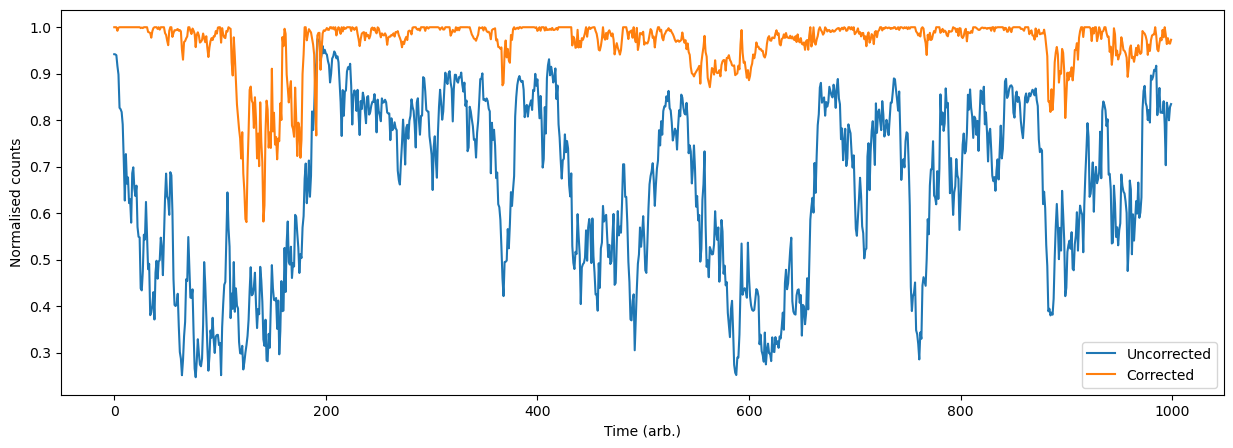

In [26]:
print("Corrected [mean:std]:\t [%.2f, %.2f]" % (np.mean(counts_cor_test / 2**16), np.std(counts_cor_test / 2**16)))
print("Uncorrected [mean:std]:\t [%.2f, %.2f]" % (np.mean(counts_test / 2**16), np.std(counts_test / 2**16)))

plt.figure(figsize=(15,5))
plt.plot(counts_test / 2**16)
plt.plot(counts_cor_test / 2**16)
plt.legend(['Uncorrected', 'Corrected'])
plt.xlabel('Time (arb.)')
plt.ylabel('Normalised counts')
plt.show()